# Case1-challenge04

At first, we add the analysis directory to the python path.

In [1]:
import sys
sys.path.append('/home/kamizuka/analysis')

At first, we load the data, 'case1_chalenge_04.txt'.

In [2]:
import astropy.io.ascii as asc
from astropy import units as u

data = asc.read('case1_challenge_04.txt')
data['x'].unit = u.um
data['y'].unit = u.um
data['ra'].unit = u.deg
data['dec'].unit = u.deg

The source distribution is shown in the figure below.

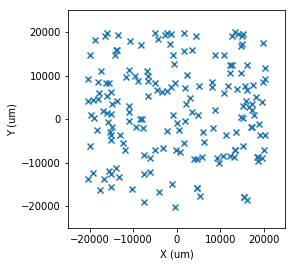

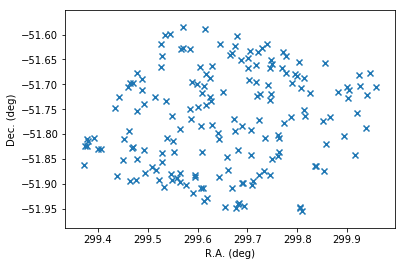

In [4]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['x'], data['y'], marker='x')
ax.set_xlabel('X (um)')
ax.set_ylabel('Y (um)')
ax.set_xlim([-25000,25000])
ax.set_ylim([-25000,25000])
ax.set_aspect('equal', adjustable='box')

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='x')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_aspect('equal', adjustable='box')

We guess the astrometric(?) parameters.

In [5]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle

r = np.sqrt(data['x']**2.+data['y']**2.)
i0 = np.argmin(r)
ra0  = data['ra'].quantity[i0]
dec0 = data['dec'].quantity[i0]

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs')
c1 = SkyCoord(ra=data['ra'].quantity[0], dec=data['dec'].quantity[0], frame='icrs')
angle_sep = c0.separation(c1)

dx = data['x'].quantity[i0] - data['x'].quantity[0]
dy = data['y'].quantity[i0] - data['y'].quantity[0]
um_sep = np.sqrt(dx*dx+dy*dy)

scale0 = angle_sep/um_sep

pa0 = 0.0 * u.deg

print(ra0)
print(dec0)
print(scale0)
print(pa0)

299.69022319750525 deg
-51.782988505491375 deg
7.84871475198839e-06 deg / um
0.0 deg


We define a model function which calculates RA and Dec from the position on the focal plane.

In [6]:
from astropy.wcs import WCS

def wcs(ra0, dec0, pa0, scale0):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale0, scale0])
    w.wcs.crval=[ra0, dec0]
    w.wcs.ctype=["RA---TAN", "DEC--TAN"]
    w.wcs.pc=[[ np.cos(pa0*u.deg), np.sin(pa0*u.deg)],
              [-np.sin(pa0*u.deg), np.cos(pa0*u.deg)]]
    return w

def model(params, pxcrd):
    ra_ptg  = params[0] # value in deg.
    dec_ptg = params[1] # value in deg.
    pa_ptg  = params[2] # value in deg.
    scale   = params[3] # value in deg/um.
    # params must be an array of dimension-less values.
    
    w = wcs(ra_ptg, dec_ptg, pa_ptg, scale)
    world = w.wcs_pix2world(pixcrd, 0)
    return world.T.flatten()

Then, we make an array of the coordinates on the focal plane.

In [7]:
pixcrd = np.concatenate(([data['x']],[data['y']])).T

And now, we estimate the astrometric(?) parameters with the LeastSquare module.

In [8]:
from common.leastsquare import LeastSquare

ls = LeastSquare(lambda a: model(a, pixcrd), np.size(data['x'])*2)

a_init = np.array([ra0.value, dec0.value, pa0.value, scale0.value]) # This must be an ndarray.

result, _ = ls.solve(np.concatenate((data['ra'], data['dec'])), a_init)

if result[3] < 0:
    result[3] = -result[3]
    result[2] = result[2] + 180.0

if result[2] > 360.0 or result[2] < 0.0:
    result[2] = result[2]%360.0

2021-07-04 13:36:53,875  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 52.132236)
2021-07-04 13:36:53,880  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 31.759194)
2021-07-04 13:36:53,884  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 18.617093)
2021-07-04 13:36:53,888  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.192478)
2021-07-04 13:36:53,892  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.009825)
2021-07-04 13:36:53,896  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-07-04 13:36:53,900  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)


The result is...

In [9]:
print("Center R.A.   : {:f} deg.".format(result[0]))
print("Center Dec.   : {:f} deg.".format(result[1]))
print("Position angle: {:f} deg.".format(result[2]))
print("Plate scale   : {:e} deg/um".format(result[3]))

Center R.A.   : 299.679351 deg.
Center Dec.   : -51.778960 deg.
Position angle: 65.456988 deg.
Plate scale   : 7.848737e-06 deg/um


According to the meta part of the input file, the poiunting RA and Dec are 299.6793506881518 and -51.77896007791029 deg, respectively. The position angle is 65.45698819455622 deg. The calculation seems to correctly estimate these parameters.

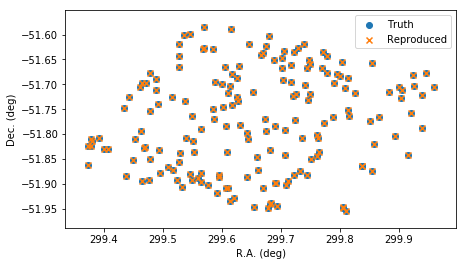

In [10]:
positions = model(result, pixcrd)
positions = positions.reshape((2,int(positions.size/2))).T

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='o', label='Truth')
ax.scatter(positions[:,0], positions[:,1], marker='x', label='Reproduced')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
#ax.set_aspect('equal', adjustable='box')
ax.legend()

The positions calculated from the estimated parameters match the true positions.